In [1]:
data = [1, 2, 3, 4, 5]

print(data[:-1])

[1, 2, 3, 4]


In [1]:
import xarray_beam as xbeam
import xarray

ds, _ = xbeam.open_zarr('gcs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-512x256_equiangular_conservative.zarr')
print(ds.nbytes / (10**9))

84453.77358148


In [46]:
import pandas as pd
import numpy as np

start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-01-03')

lat_min, lat_max = (20, 45)
lon_min, lon_max = (115, 140)

# 해당 범위에 속하는 위도와 경도의 인덱스 d
lat_indices = np.where((ds.latitude >= lat_min) & (ds.latitude <= lat_max))[0]
lon_indices = np.where((ds.longitude >= lon_min) & (ds.longitude <= lon_max))[0]

source_dataset = ds.sel(time=slice(start_date, end_date))

source_dataset = source_dataset.isel(latitude=lat_indices, longitude=lon_indices).transpose('time', 'level', 'latitude', 'longitude')

print(source_dataset)

<xarray.Dataset>
Dimensions:                                           (time: 49, longitude: 36,
                                                       latitude: 36, level: 37)
Coordinates:
  * latitude                                          (latitude) float64 20.0...
  * level                                             (level) int64 1 2 ... 1000
  * longitude                                         (longitude) float64 115...
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/48)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 ...
    10m_v_component_of_wind                           (time, latitude, longitude) float32 ...
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 ...
    2m_temperature                                    (time, latitude, longitude) float32 ...
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 ..

In [55]:
dataset = source_dataset['2m_temperature']

print(dataset)

<xarray.DataArray '2m_temperature' (time: 49, latitude: 36, longitude: 36)>
[63504 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 20.04 20.74 21.45 22.15 ... 43.24 43.95 44.65
  * longitude  (longitude) float64 115.3 116.0 116.7 117.4 ... 138.5 139.2 139.9
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-01-03
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K


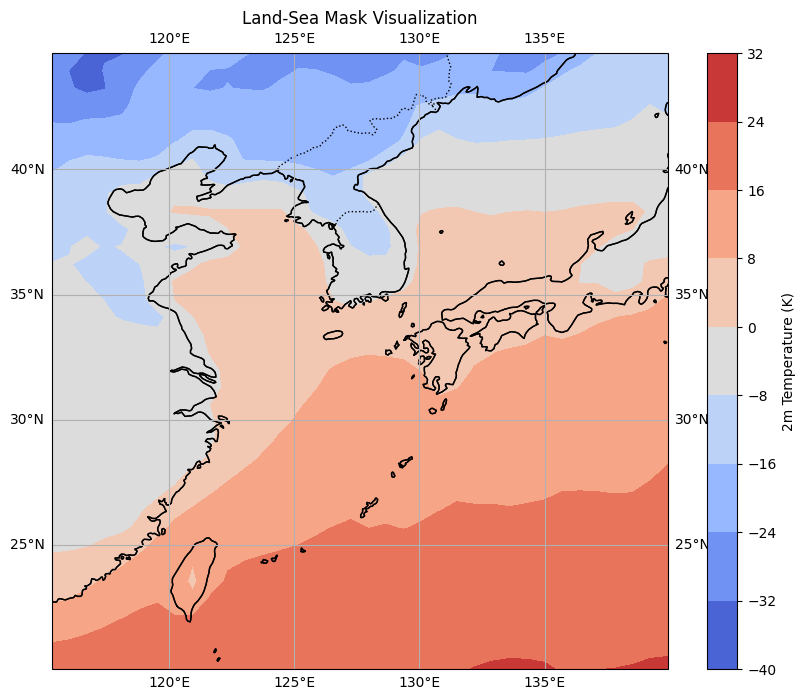

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

dataset = dataset.isel(time=0) - 273.15

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# 땅과 바다 구분을 위해, 0.5를 기준으로 땅(1)과 바다(0)를 구분
# cmap을 'binary'로 설정하여 땅과 바다를 명확하게 구분
plt.contourf(dataset.longitude.values, dataset.latitude.values, dataset.values, transform=ccrs.PlateCarree(), cmap='coolwarm')

plt.colorbar(label='2m Temperature (K)')

# 기본 지도 추가
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.title('Land-Sea Mask Visualization')
plt.show()